# Calcul et Visualisation de la HGL (version corrigée)
Ce notebook reprend le calcul et la visualisation de la HGL avec gestion robuste des valeurs manquantes.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
g = 9.81  # gravité
stations = {
    'Head': {'elevation_m': 650, 'distance_km': 0},
    'PMS1': {'elevation_m': 680, 'distance_km': 45},
    'VANNE': {'elevation_m': 515, 'distance_km': 68},
    'PMS2': {'elevation_m': 360, 'distance_km': 101},
    'PMS3': {'elevation_m': 110, 'distance_km': 130},
    'PMS4': {'elevation_m': 143, 'distance_km': 162},
    'Terminal': {'elevation_m': 60, 'distance_km': 187}
}

In [25]:
# Charger le dataset fusionné
merged_df = pd.read_csv('./new_dataset/Merged_All_Stations_updated.csv', sep=',', decimal='.', engine='python')
for col in ['Density_HS_Average', 'Density_PMS1', 'Density_VANNE', 'Density_PMS2', 'Density_PMS3', 'Density_PMS4', 'Density_T',
            'Pressure_HS_Average', 'Pressure_PMS1', 'Pressure_VANNE', 'Pressure_PMS2', 'Pressure_PMS3', 'Pressure_PMS4', 'Pressure_T']:
    if col in merged_df.columns:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

In [26]:
river_crossings = [
    {'start_km': 60, 'end_km': 65, 'water_elev_m': 1150},
    {'start_km': 150, 'end_km': 152, 'water_elev_m': 1080},
]
def adjust_elevation(distance, base_elevation, river_crossings):
    for river in river_crossings:
        if river['start_km'] <= distance <= river['end_km']:
            return river['water_elev_m']
    return base_elevation

In [27]:
def calculate_HGL(row, station):
    stations_columns = {
        'Head': 'HS',
        'PMS1': 'PMS1',
        'VANNE': 'VANNE',
        'PMS2': 'PMS2',
        'PMS3': 'PMS3',
        'PMS4': 'PMS4',
        'Terminal': 'T'
    }
    prefix = stations_columns[station]
    P_col = f'Pressure_{prefix}' if prefix != 'HS' else 'Pressure_HS_Average'
    rho_col = f'Density_{prefix}' if prefix != 'HS' else 'Density_HS_Average'
    P = row.get(P_col, None)
    rho = row.get(rho_col, None)
    if pd.isna(P) or pd.isna(rho):
        return None
    P = P * 1e5
    dist = stations[station]['distance_km']
    z = stations[station]['elevation_m']
    z_adjusted = adjust_elevation(dist, z, river_crossings)
    return ((P * 0.10197) / (rho * g)) + z_adjusted

In [28]:
for station in stations:
    merged_df[f'HGL_{station}'] = merged_df.apply(lambda row: calculate_HGL(row, station), axis=1)

In [29]:
merged_df.to_csv("./new_dataset/HGL_dataset.csv", index=False)

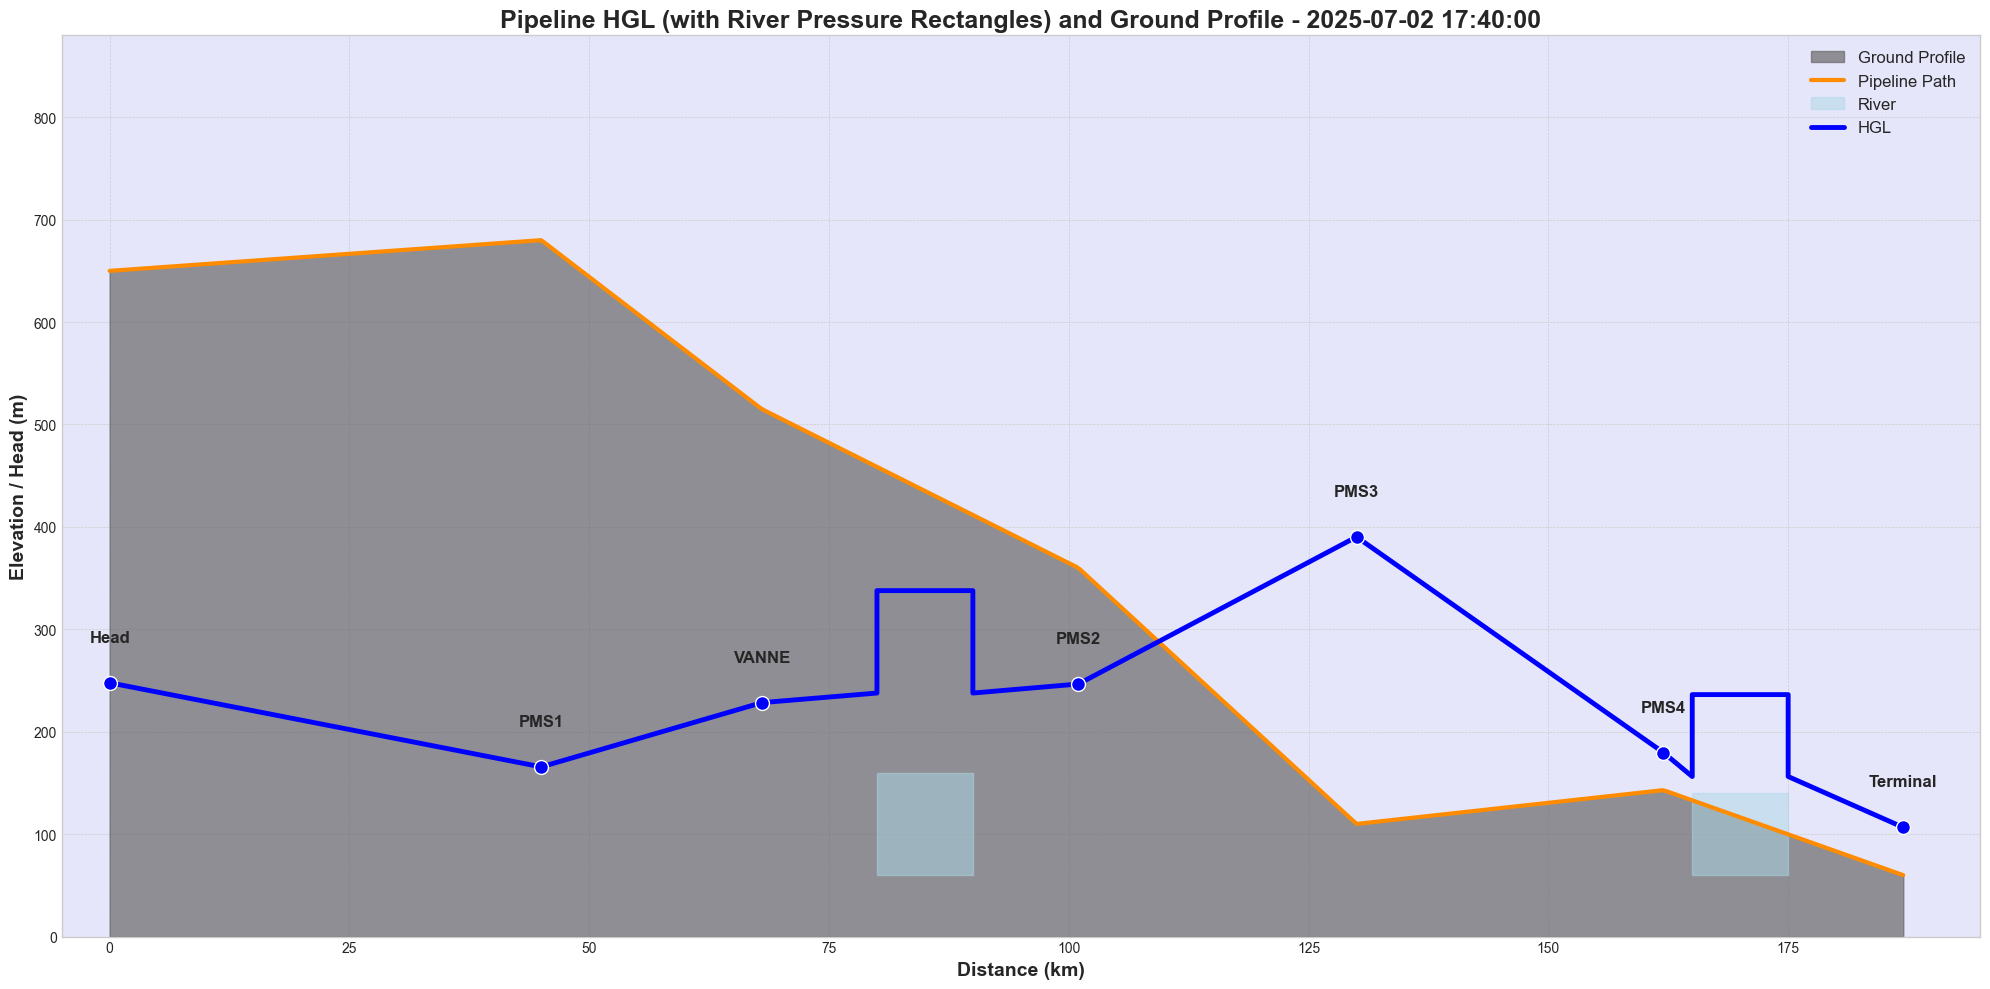

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Data Setup ---
stations = {
    'Head': {'elevation_m': 650, 'distance_km': 0},
    'PMS1': {'elevation_m': 680, 'distance_km': 45},
    'VANNE': {'elevation_m': 515, 'distance_km': 68},
    'PMS2': {'elevation_m': 360, 'distance_km': 101},
    'PMS3': {'elevation_m': 110, 'distance_km': 130},
    'PMS4': {'elevation_m': 143, 'distance_km': 162},
    'Terminal': {'elevation_m': 60, 'distance_km': 187}
}

river_crossings = [
    {"start_km": 80, "end_km": 90, "rise_height_m": 100},
    {"start_km": 165, "end_km": 175, "rise_height_m": 80}
]

# --- 2. Load HGL Data ---
try:
    merged_df = pd.read_csv("./new_dataset/HGL_dataset.csv", sep=',', decimal='.', engine='python')
except FileNotFoundError:
    print("Error: 'HGL_dataset.csv' not found.")
    exit()

def generate_ground_profile(stations, num_points=500):
    station_names = list(stations.keys())
    distances = np.array([stations[s]['distance_km'] for s in station_names])
    elevations = np.array([stations[s]['elevation_m'] for s in station_names])
    dist_interp = np.linspace(min(distances), max(distances), num_points)
    elev_interp = np.interp(dist_interp, distances, elevations)
    return dist_interp, elev_interp

def create_separated_hgl_plot(snapshot, stations, rivers):
    station_names = list(stations.keys())
    station_distances = [stations[s]['distance_km'] for s in station_names]
    hgl_values_raw = [snapshot.get(f'HGL_{s}', None) for s in station_names]
    scaling_factor = 10.0
    hgl_values_scaled = [v / scaling_factor if v is not None else None for v in hgl_values_raw]
    ground_dist, ground_elev = generate_ground_profile(stations)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_facecolor('#E6E6FA')
    ax.fill_between(ground_dist, 0, ground_elev, color='#696969', alpha=0.7, label="Ground Profile")
    ax.plot(ground_dist, ground_elev, color='#FF8C00', linewidth=3, label="Pipeline Path")
    for idx, river in enumerate(river_crossings):
        river_elev = min(ground_elev) + river["rise_height_m"]
        plt.fill_between([
            river["start_km"], river["end_km"]],
            river_elev,
            min(ground_elev),
            color='lightblue', alpha=0.5,
            label="River" if idx == 0 else None
        )
    for i, name in enumerate(station_names):
        dist = station_distances[i]
        hgl_val = hgl_values_scaled[i]
        if hgl_val is None:
            continue
        ax.plot(dist, hgl_val, 'o', markersize=10, color='blue', markeredgecolor='white', zorder=10)
        ax.text(dist, hgl_val + 40, name, ha='center', fontsize=12, fontweight='bold')
    hgl_path_x = []
    hgl_path_y = []
    for i in range(len(station_distances) - 1):
        x0, y0 = station_distances[i], hgl_values_scaled[i]
        x1, y1 = station_distances[i+1], hgl_values_scaled[i+1]
        if y0 is None or y1 is None:
            continue
        hgl_path_x.append(x0)
        hgl_path_y.append(y0)
        for river in rivers:
            if river["start_km"] >= x0 and river["end_km"] <= x1:
                mid = (river["start_km"] + river["end_km"]) / 2
                base_level = np.interp(mid, [x0, x1], [y0, y1])
                rise = river["rise_height_m"]
                hgl_path_x.extend([river["start_km"], river["start_km"], river["end_km"], river["end_km"]])
                hgl_path_y.extend([base_level, base_level + rise, base_level + rise, base_level])
        hgl_path_x.append(x1)
        hgl_path_y.append(y1)
    ax.plot(hgl_path_x, hgl_path_y, 'b-', linewidth=3.5, label="HGL")
    ax.set_xlabel('Distance (km)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Elevation / Head (m)', fontsize=14, fontweight='bold')
    title = 'Pipeline HGL (with River Pressure Rectangles) and Ground Profile'
    if 'Date' in snapshot and pd.notna(snapshot.get("Date", None)):
        title += f' - {snapshot["Date"]}'
    ax.set_title(title, fontsize=18, fontweight='bold')
    min_y = 0
    max_y = max(np.max(ground_elev), max([v for v in hgl_values_scaled if v is not None])) + 200 if any(hgl_values_scaled) else np.max(ground_elev) + 200
    ax.set_ylim(0, max_y)
    ax.set_xlim(-5, 195)
    ax.legend(loc='best', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

hgl_columns_required = [f'HGL_{s}' for s in stations.keys()]
df_cleaned = merged_df.dropna(subset=hgl_columns_required).copy()
if not df_cleaned.empty:
    for col in hgl_columns_required:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    df_cleaned.dropna(subset=hgl_columns_required, inplace=True)
    if not df_cleaned.empty:
        snapshot_to_plot = df_cleaned.iloc[500]
        create_separated_hgl_plot(snapshot_to_plot, stations, river_crossings)
    else:
        print("Error: HGL columns contain non-numeric or missing data.")

In [31]:
import tensorflow as tf
print(f"model_utils.py - TensorFlow Version: {tf.__version__}")
print(f"model_utils.py - Keras Version: {tf.keras.__version__}")

model_utils.py - TensorFlow Version: 2.16.2
model_utils.py - Keras Version: 3.10.0
